In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from collections import defaultdict
import os
import pymysql
import scipy
from tqdm import tqdm
import ast
import utils
import importlib

In [898]:
importlib.reload(utils)
connection = utils.connectDB()

In [899]:
query = 'SELECT * FROM ebdb.ChatGPT;'
gpt = pd.read_sql(query, connection)

In [900]:
gpt = gpt[~gpt["response"].isna()]
gpt = gpt[gpt["response"]!=""]
gpt = gpt[gpt["annotator_id"].isin([20,21,22])]

In [901]:
gpt[gpt["feature_id"]=="Verb_choices"].loc[482]["prompt"]

'\n        You are a rhetoretician and linguist specializing in news text. \n\n        Your task is to identify which, if any, of the following properties of Verb choices are used in the example text. \n        You may select multiple properties.\n        Each line contains a property followed by a colon, followed by a brief definition and example(s):\n        \n        negation : the contradiction or denial of something.\nmodality : language of possibilities with modifiers like \'might\', \'likely\', \'perhaps\'\nnominalization : the practice of turning verbs into nouns (polyptoton). Example: given the sentence \'Irene Curie recieved the Nobel Prize.\', the nominalized version would be \'Irene Curie was the recipient of the Nobel Prize.\'\npersonification : endowing physical objects and abstractions with human-like agency. Example: \'The nation weeps for her lost sons.\'\nmultiplication : multiplying the subjects or verbs in a single predication. Example: \'We shall pay any price, bea

In [902]:
sentences = gpt['sentence_id'].unique()
len(sentences)

324

In [903]:
features = gpt['feature_id'].unique()

In [904]:
print(len(features))
features

21


array(['Aspect', 'Verb_choices', 'Language_of_origin',
       'Modifying_clauses', 'New_words_and_changing_uses',
       'Modifying_phrases', 'Sentence_architecture', 'Emphasis',
       'Lexical_and_semantic_fields', 'Language_varieties', 'Tropes',
       'Predication', 'Subject_choices', 'Tense', 'Mood',
       'Phrases_built_on_verbs', 'Phrases_built_on_nouns',
       'Figures_of_word_choice', 'Figures_of_argument', 'Series',
       'Parallelism'], dtype=object)

In [905]:
responses = list(gpt.groupby('feature_id').agg(list)[['response']].loc["Aspect"])

In [906]:
i = 1
json.loads(responses[0][i])['Properties']

['simple']

## How consistent is ChatGPT with itself?
For each sentence, make a set of the properties returned by GPT for each feature.   
If the set contains more than a single property it means that GPT was inconsistent in determining the property of a given feature. The function below returns the number of properties in each feature set.


In [912]:
importlib.reload(utils)
res_df = utils.getGPTFeatures(gpt)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:41<00:00,  7.87it/s]


In [908]:
len(gpt)

20185

In [913]:
res_df

,sentence_id,count,properties,feature_id
0,265,1,[{simple}],Aspect
1,265,0,[],Verb_choices
2,265,1,[{subordinate}],Modifying_clauses
3,265,1,"[{multiplying and embedding modifiers, single ...",Modifying_phrases
4,265,1,"[{Periodic sentences, left branching, middle b...",Sentence_architecture
...,...,...,...,...
4839,15233,1,[{appositives}],Phrases_built_on_nouns
4840,15233,1,"[{multiplying and embedding modifiers, single ...",Modifying_phrases
4841,15233,2,"[{right branching, left branching}, {multiplyi...",Sentence_architecture
4842,15233,2,"[{right branching, left branching}, {by senten...",Emphasis


# GPT Partially consistent features

In [35]:
_res_df = pd.read_csv("data/GPT/corrected_GPT_min.csv")
# _res_df = _res_df[["sentence_id","all_properties","feature_id"]]
_res_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,['simple']
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,['indicative']
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"['subordinate', 'adjective']"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"['prepositional phrases', 'single word modifie..."


In [36]:
_res_df["feature_id"].unique()

array(['Aspect', 'Mood', 'Verb_choices', 'Modifying_clauses',
       'Modifying_phrases', 'Sentence_architecture', 'Emphasis',
       'Language_of_origin', 'New_words_and_changing_uses',
       'Lexical_and_semantic_fields', 'Language_varieties', 'Tropes',
       'Predication', 'Subject_choices', 'Tense',
       'Phrases_built_on_verbs', 'Figures_of_word_choice',
       'Phrases_built_on_nouns', 'Figures_of_argument', 'Series',
       'Parallelism'], dtype=object)

In [5]:
_res_df["all_properties"] = _res_df["all_properties"].apply(lambda x: ast.literal_eval(x))
_res_df['all_properties_count'] = _res_df["all_properties"].apply(lambda l: len(l))

In [6]:
# cannot take set intersetion of empty list
_res_df = _res_df[_res_df["all_properties_count"]!=0]

In [7]:
_res_df['set_properties'] = _res_df["all_properties"].apply(lambda lis: set.intersection(*lis))
_res_df['set_properties_count'] = _res_df["set_properties"].apply(lambda l: len(l))

In [8]:
print(len(_res_df))
_res_df.head()

4740


,sentence_id,all_properties,feature_id,majority_prop,all_properties_count,set_properties,set_properties_count
0,265,"[{simple}, {simple}, {simple}, {simple}, {simp...",Aspect,['simple'],5,{simple},1
1,265,"[{indicative}, {indicative}, {indicative}]",Mood,['indicative'],3,{indicative},1
3,265,"[{subordinate}, {adjective, subordinate}, {adj...",Modifying_clauses,"['subordinate', 'adjective']",3,{subordinate},1
4,265,"[{multiplying and embedding modifiers, preposi...",Modifying_phrases,"['prepositional phrases', 'single word modifie...",5,"{multiplying and embedding modifiers, single w...",3
5,265,"[{middle branching, Periodic sentences, left b...",Sentence_architecture,"['Periodic sentences', 'left branching', 'midd...",3,"{middle branching, left branching, Periodic se...",3


In [9]:
_res_df = _res_df[['sentence_id', 'feature_id', 'all_properties','all_properties_count',
       'set_properties', 'set_properties_count']]

In [10]:
_res_df.head()

,sentence_id,feature_id,all_properties,all_properties_count,set_properties,set_properties_count
0,265,Aspect,"[{simple}, {simple}, {simple}, {simple}, {simp...",5,{simple},1
1,265,Mood,"[{indicative}, {indicative}, {indicative}]",3,{indicative},1
3,265,Modifying_clauses,"[{subordinate}, {adjective, subordinate}, {adj...",3,{subordinate},1
4,265,Modifying_phrases,"[{multiplying and embedding modifiers, preposi...",5,"{multiplying and embedding modifiers, single w...",3
5,265,Sentence_architecture,"[{middle branching, Periodic sentences, left b...",3,"{middle branching, left branching, Periodic se...",3


In [11]:
partial_res_df = _res_df.groupby('set_properties_count').count().reset_index()
partial_res_df['consistency'] = partial_res_df['set_properties_count'].apply(lambda x: 'inconsistent' if x==0 else 'consistent')

In [12]:
partial_res_df

,set_properties_count,sentence_id,feature_id,all_properties,all_properties_count,set_properties,consistency
0,0,834,834,834,834,834,inconsistent
1,1,2497,2497,2497,2497,2497,consistent
2,2,993,993,993,993,993,consistent
3,3,330,330,330,330,330,consistent
4,4,69,69,69,69,69,consistent
5,5,17,17,17,17,17,consistent


In [13]:
# group all non-1 counts into a single row 
partial_res_df = partial_res_df.groupby('consistency').sum().reset_index()
partial_res_df

,consistency,set_properties_count,sentence_id,feature_id,all_properties,all_properties_count,set_properties
0,consistent,15,3906,3906,3906,3906,3906
1,inconsistent,0,834,834,834,834,834


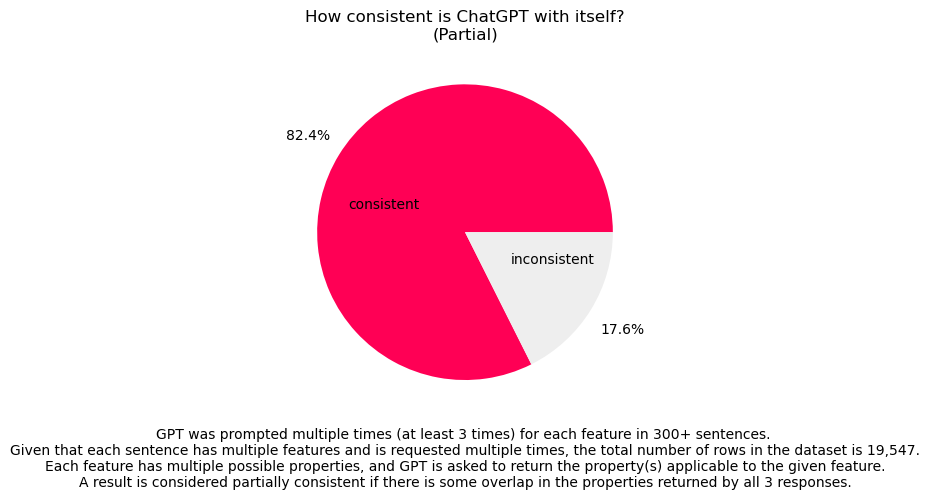

In [14]:
labels = partial_res_df['consistency']
sizes = partial_res_df['feature_id']

fig, ax = plt.subplots()
plt.title("How consistent is ChatGPT with itself?\n(Partial)")
plt.xlabel('''GPT was prompted multiple times (at least 3 times) for each feature in 300+ sentences. 
Given that each sentence has multiple features and is requested multiple times, the total number of rows in the dataset is 19,547.
Each feature has multiple possible properties, and GPT is asked to return the property(s) applicable to the given feature.
A result is considered partially consistent if there is some overlap in the properties returned by all 3 responses.''')


ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.36, colors=["#ff0055","#eeeeee"])
plt.show()
fig.savefig("gpt_partial_pie.svg", format="svg")

# sentences where all features are consistent
There are very few sentences where all the features are always consistent.

In [15]:
# sentences which have consistent results for some features (but not necessarily all features)
consitent_sentence_ids = _res_df[_res_df['set_properties_count']==1]['sentence_id'].unique()

In [16]:
# All sentences have some consistent features
len(consitent_sentence_ids)

324

In [17]:
# group by sentence_id and count number of rows, and sum the 'count' column. 
# these will be equal if all the features hava a count of 1, if they are equal, then all features for the given sentence are consistent

all_consistent_sentence_ids = _res_df.groupby('sentence_id').agg({'sentence_id':list,'set_properties_count':sum})
all_consistent_sentence_ids['sentence_id_len'] = all_consistent_sentence_ids['sentence_id'].apply(lambda x: len(x))
all_consistent_sentence_ids.head()

,sentence_id,set_properties_count,sentence_id_len
sentence_id,,,
47,"[47, 47, 47]",5,3
219,"[219, 219, 219, 219, 219, 219, 219, 219, 219, ...",24,16
265,"[265, 265, 265, 265, 265, 265]",11,6
271,"[271, 271, 271, 271, 271, 271, 271, 271, 271, ...",22,16
275,"[275, 275, 275, 275, 275, 275, 275, 275, 275, ...",17,17


In [18]:
# Number of sentences where all features are always consistent
all_consistent_sentence_ids['consistent'] = all_consistent_sentence_ids["sentence_id_len"] == all_consistent_sentence_ids["set_properties_count"]
all_consistent_sentence_ids.groupby('consistent').count()

,sentence_id,set_properties_count,sentence_id_len
consistent,,,
False,295,295,295
True,29,29,29


In [19]:
all_consistent_sentence_ids['unique_ids'] = all_consistent_sentence_ids['sentence_id'].apply(lambda x: set(x))
all_consistent_sentence_ids = all_consistent_sentence_ids.groupby('consistent').agg(list)
all_consistent_sentence_ids = [list(x)[0] for x in all_consistent_sentence_ids['unique_ids'].loc[True]]

In [20]:
len(all_consistent_sentence_ids)

29

# features which are exactly consistent

In [21]:
# returns number of consistent features within all sentences

In [22]:
exact_res_df = _res_df.groupby('set_properties_count').count().reset_index()
exact_res_df['consistency'] = exact_res_df['set_properties_count'].apply(lambda x: 'consistent' if x==1 else 'inconcsitent')

In [23]:
# count is the number of different features (this is a set - see above). If 1, then we have consistency
# sentence_id and feature are the number of rows for the given count
exact_res_df

,set_properties_count,sentence_id,feature_id,all_properties,all_properties_count,set_properties,consistency
0,0,834,834,834,834,834,inconcsitent
1,1,2497,2497,2497,2497,2497,consistent
2,2,993,993,993,993,993,inconcsitent
3,3,330,330,330,330,330,inconcsitent
4,4,69,69,69,69,69,inconcsitent
5,5,17,17,17,17,17,inconcsitent


In [24]:
# group all non-1 counts into a single row 
exact_res_df = exact_res_df.groupby('consistency').sum().reset_index()
exact_res_df

,consistency,set_properties_count,sentence_id,feature_id,all_properties,all_properties_count,set_properties
0,consistent,1,2497,2497,2497,2497,2497
1,inconcsitent,14,2243,2243,2243,2243,2243


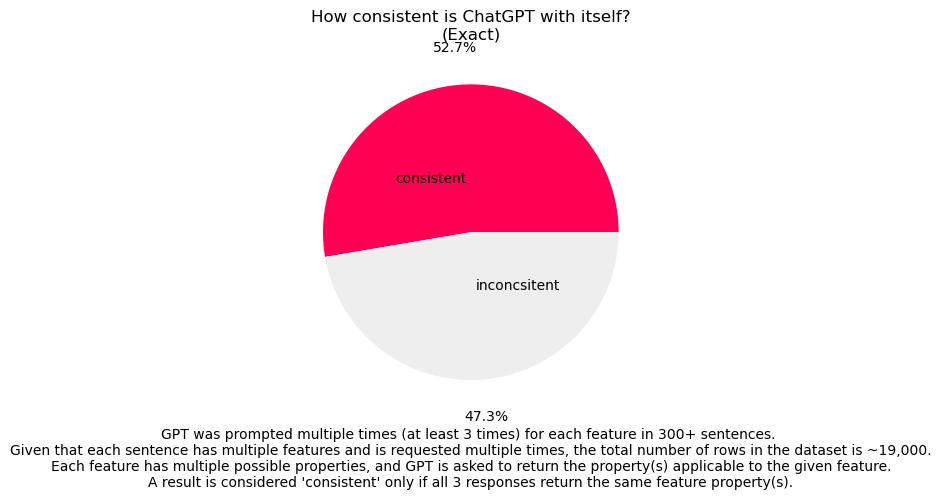

In [25]:
labels = exact_res_df['consistency']
sizes = exact_res_df['feature_id']

fig, ax = plt.subplots()
plt.title("How consistent is ChatGPT with itself?\n(Exact)")
plt.xlabel('''GPT was prompted multiple times (at least 3 times) for each feature in 300+ sentences. 
Given that each sentence has multiple features and is requested multiple times, the total number of rows in the dataset is ~19,000.
Each feature has multiple possible properties, and GPT is asked to return the property(s) applicable to the given feature.
A result is considered 'consistent' only if all 3 responses return the same feature property(s).''')


ax.pie(sizes, labels=labels, autopct='%1.1f%%',
       pctdistance=1.25, labeldistance=.36, colors=["#ff0055","#eeeeee"])
plt.show()

# Consistency per property

In [26]:
_res_df.head()

,sentence_id,feature_id,all_properties,all_properties_count,set_properties,set_properties_count
0,265,Aspect,"[{simple}, {simple}, {simple}, {simple}, {simp...",5,{simple},1
1,265,Mood,"[{indicative}, {indicative}, {indicative}]",3,{indicative},1
3,265,Modifying_clauses,"[{subordinate}, {adjective, subordinate}, {adj...",3,{subordinate},1
4,265,Modifying_phrases,"[{multiplying and embedding modifiers, preposi...",5,"{multiplying and embedding modifiers, single w...",3
5,265,Sentence_architecture,"[{middle branching, Periodic sentences, left b...",3,"{middle branching, left branching, Periodic se...",3


In [27]:
feature_res_df = _res_df.groupby('feature_id').agg(list).reset_index()
feature_res_df.head()

,feature_id,sentence_id,all_properties,all_properties_count,set_properties,set_properties_count
0,Aspect,"[265, 446, 311, 3326, 3374, 313, 3387, 271, 33...","[[{simple}, {simple}, {simple}, {simple}, {sim...","[5, 8, 3, 5, 5, 3, 3, 10, 11, 4, 5, 3, 7, 13, ...","[{simple}, {simple}, {simple}, {}, {simple}, {...","[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, ..."
1,Emphasis,"[265, 446, 311, 3326, 3374, 313, 3387, 271, 33...","[[{by position, by sentence role}, {by positio...","[3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[{by position, by sentence role}, {by position...","[2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, ..."
2,Figures_of_argument,"[311, 3374, 313, 3387, 271, 3397, 3407, 275, 3...","[[{antithesis}, {antithesis}, {antithesis}], [...","[3, 3, 3, 3, 3, 3, 1, 3, 1, 3, 3, 3, 3, 3, 3, ...","[{antithesis}, {strategic repetition}, {antith...","[1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, ..."
3,Figures_of_word_choice,"[311, 3326, 3374, 313, 3387, 271, 3397, 3407, ...","[[{agnominatio}, {emphasis, agnominatio}, {emp...","[3, 3, 3, 4, 3, 3, 3, 3, 8, 3, 4, 5, 2, 5, 3, ...","[{agnominatio}, {emphasis}, {emphasis}, {ploce...","[1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 2, 0, 1, 1, ..."
4,Language_of_origin,"[446, 311, 3326, 3374, 313, 3387, 271, 3397, 3...","[[{Old English Core, Latin/Greek}, {Old Englis...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[{Old English Core, Latin/Greek}, {Old English...","[2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 2, 1, 3, 1, 2, ..."


In [28]:
set.intersection({'progressive'}, {'simple'}, {'simple'}, {'simple'}, {'simple'})

set()

In [30]:
feature_res_df.loc[0]["all_properties"]

[[{'simple'}, {'simple'}, {'simple'}, {'simple'}, {'simple'}],
 [{'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'}],
 [{'simple'}, {'simple'}, {'simple'}],
 [{'progressive'}, {'simple'}, {'simple'}, {'simple'}, {'simple'}],
 [{'simple'}, {'simple'}, {'simple'}, {'simple'}, {'simple'}],
 [{'simple'}, {'simple'}, {'simple'}],
 [{'progressive', 'simple'}, {'simple'}, {'simple'}],
 [{'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'}],
 [{'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'active', 'compound'}],
 [{'simple'}, {'simple'}, {'simple'}, {'simple'}],
 [{'simple'}, {'simple'}, {'simple'}, {'simple'}, {'simple'}],
 [{'simple'}, {'simple'}, {'simple'}],
 [{'simple'},
  {'simple'},
  {'future', 'present'},
  {'simple'},
  {'simple'},
  {'simple'},
  {'s

In [31]:
feature_res_df.loc[0]["set_properties"]

[{'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 set(),
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 {'perfect'},
 {'perfect'},
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'progressive'},
 {'simple'},
 {'simple'},
 {'simple'},
 {'progressive', 'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'simple'},
 set(),
 {'simple'},
 {'progressive'}

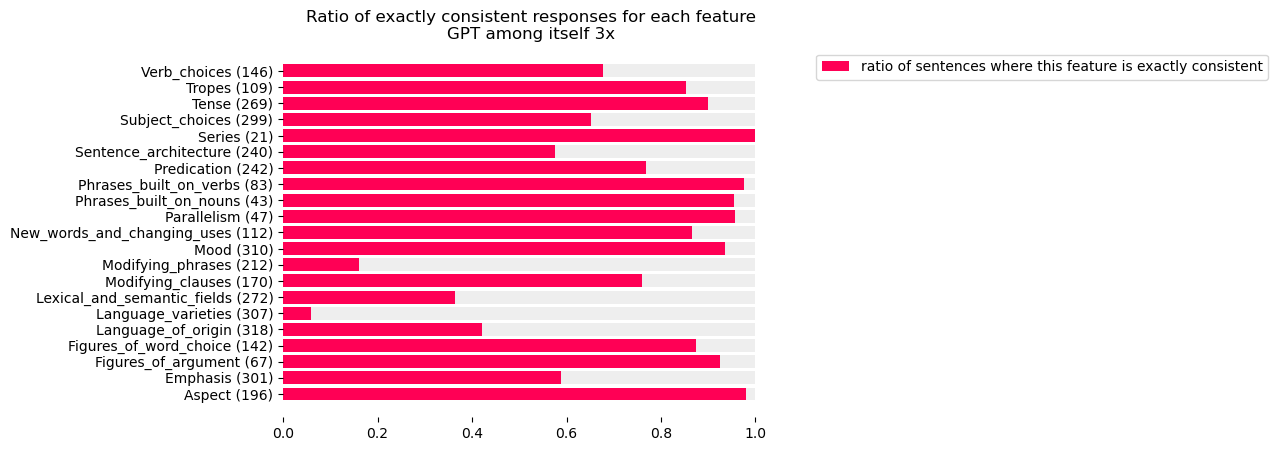

In [32]:
X = []
Y = []
Y2 =[1.0]*len(feature_res_df)


for row in feature_res_df.iterrows():
    
    
    c = Counter(row[1][5]) #set_properties_count
    
    # remove the data where the key is 0 (count of 0s)
    del c[0]
    
    # print(c, sum(c.values()))
    
    x = row[1][0] +" (" + str(sum(c.values()))+")" # feature name and number of datapoints
    
    consistent = c[1]
    inconsistent = sum(c.values()) - consistent
    
    y = consistent/(sum(c.values()))
    
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055", label="ratio of sentences where this feature is exactly consistent")
ax.set_frame_on(False)
ax.set_title('Ratio of exactly consistent responses for each feature\nGPT among itself 3x')
plt.legend(loc='upper right', bbox_to_anchor=(2, 1.0))
fig.savefig("gpt_exact_barh.svg",format="svg")
plt.show()

In [34]:
Y

[0.9795918367346939,
 0.5880398671096345,
 0.9253731343283582,
 0.8732394366197183,
 0.42138364779874216,
 0.05863192182410423,
 0.3639705882352941,
 0.7588235294117647,
 0.16037735849056603,
 0.9354838709677419,
 0.8660714285714286,
 0.9574468085106383,
 0.9534883720930233,
 0.9759036144578314,
 0.768595041322314,
 0.575,
 1.0,
 0.6521739130434783,
 0.8996282527881041,
 0.8532110091743119,
 0.678082191780822]

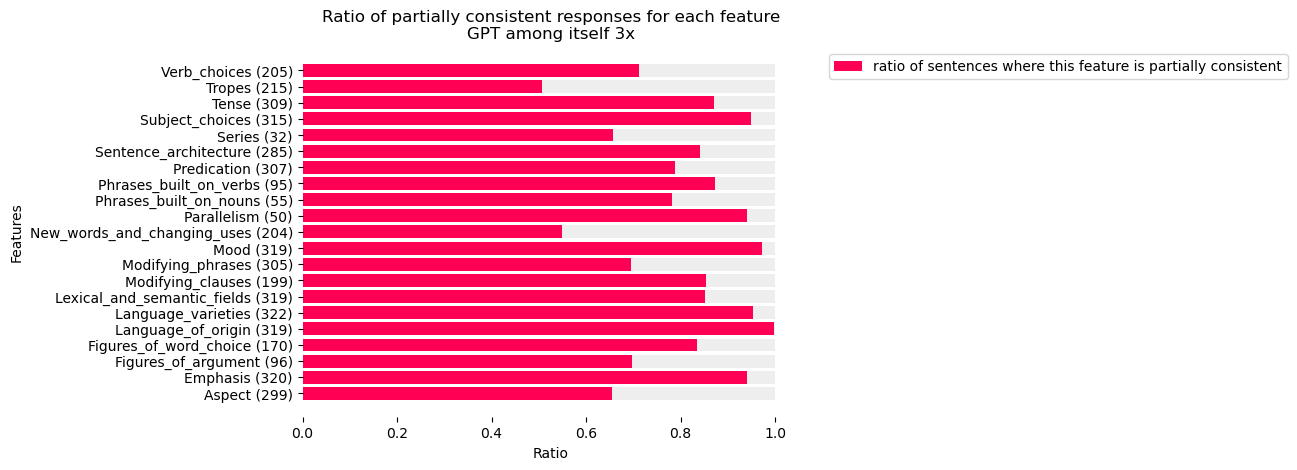

In [1024]:
X = []
Y = []
# Y2 =[len(compare_sentences)]*len(feature_res_df)
Y2 =[1.0]*len(feature_res_df)
Y3 = []

for row in feature_res_df.iterrows():
   
    c = Counter(row[1][5])
    
    x = row[1][0] +" (" + str(sum(c.values()))+")" # feature name and number of datapoints
    
    
    inconsistent = c[0]
    consistent = sum(c.values()) - inconsistent
    
    y = consistent/(sum(c.values()))
    
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055", label="ratio of sentences where this feature is partially consistent")
ax.set_frame_on(False)
ax.set_xlabel('Ratio')
ax.set_ylabel('Features')
ax.set_title('Ratio of partially consistent responses for each feature\nGPT among itself 3x')
plt.legend(loc='upper right', bbox_to_anchor=(2, 1.0))
fig.savefig("gpt_partial_barh.svg",format="svg")
plt.show()

# Compare GPT to each annotator
For simplicity, we'll only use the sentences where GPT is consistent

In [807]:
# in these sentences all features are always consitent. These sentences are always labeled exactly the same
all_consistent_sentence_ids 

[47, 265, 271, 319, 320, 650, 14038]

In [808]:
consistent_gpt = gpt[gpt['sentence_id'].isin(all_consistent_sentence_ids)]

In [809]:
consistent_gpt = consistent_gpt[['sentence_id','feature_id','response']]
consistent_gpt['properties'] = consistent_gpt['response'].apply(lambda x: json.loads(x)['Properties'] if type(x) is not float and x[0] == "{" else None)
consistent_gpt = consistent_gpt[['sentence_id','feature_id','properties']]
consistent_gpt = consistent_gpt.dropna()

In [811]:
# remove duplicate rows
consistent_gpt = consistent_gpt.groupby(['sentence_id','feature_id']).agg(list).reset_index()
consistent_gpt['properties'] = consistent_gpt['properties'].apply(lambda x: x[0])

In [813]:
print(len(consistent_gpt))
consistent_gpt.head()

59


,sentence_id,feature_id,properties
0,47,New_words_and_changing_uses,[]
1,47,Predication,"[active, stative]"
2,47,Subject_choices,"[humans, rhetorical participants]"
3,265,Aspect,[simple]
4,265,Emphasis,"[by position, by sentence role]"


# Get the annotators data

This data is parsed so that all the features are considered as belonging to the sentence rather than individual nodes. Duplicates are resolved (where two nodes share the same feature, the feature is consolidated and the properties are set-ized). This is so that we can compare to the GPT responses which are recorded at the sentence level. 



In [814]:
MYSQL_HOST = "awseb-e-hhisp4zjag-stack-awsebrdsdatabase-vaxzasykqxcd.cc10tt1hevke.us-east-1.rds.amazonaws.com"
MYSQL_USER = "ann"
MYSQL_PASSWORD = "rhet-ann"
MYSQL_DB = "ebdb"
connection = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, database=MYSQL_DB)

In [815]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [816]:
print(len(annotations))
annotations.head()

1037


,id,json_string,annotator_id,sentence_id,review_flag,completed,date_updated
0,65,"{""article_id"": ""7651970399"", ""sentence_id"": 4,...",22,4,0,1,2023-07-20 13:37:51
1,66,"{""article_id"": ""7651970399"", ""sentence_id"": 4,...",20,4,0,1,2023-07-31 19:51:31
2,67,"{""article_id"": ""729578579"", ""sentence_id"": 11,...",22,11,0,1,2023-07-21 08:07:10
3,68,"{""article_id"": ""711566593"", ""sentence_id"": 14,...",22,14,0,1,2023-07-21 08:42:45
4,69,"{""article_id"": ""738060046"", ""sentence_id"": 16,...",22,16,0,1,2023-07-21 09:23:23


In [817]:
def get_all_properties(node,all_properties):
    all_properties.append([node['name'],node['properties']])
    if 'children' in node:
        for child in node['children']:
            get_all_properties(child,all_properties)
            
    return all_properties

In [818]:
def getAllSentences(_id):
    all_sentences = []
    df = annotations[annotations['annotator_id']==_id]
    for row in df.iterrows():
        node = json.loads(row[1]['json_string'])
        all_sentences.append([row[1]['sentence_id'],row[1]['date_updated'],get_all_properties(node,[])])
    return all_sentences

In [819]:
def getAllFeatures(all_sentences):
    all_features_dict = []
    for sentence in all_sentences:

        feature_dict = defaultdict(list)

        sentence_id = sentence[0]
        date_updated = sentence[1]
        annotation = sentence[2]

        for node in annotation:

            # node: ['RB', [{'Modifying_phrases': ['single_word_modifiers']}]]
            # ignore the node label by taking just the first element: data = [{'Modifying_phrases': ['single_word_modifiers']}]
            data = node[1]

            for _obj in data:

                feature = list(_obj.keys())[0] # 'Modifying_phrases'
                properties = _obj[feature] # ['single_word_modifiers']

                for prop in properties:
                    feature_dict[feature].append(prop)

        # Since features can appear multiple times, and each can have multiple properties, 
        # we take only the unique properties per feature by applying the set() funtion.
        feature_dict = {k: list(set(v)) for k, v in feature_dict.items()}   

        all_features_dict.append([sentence_id,date_updated,feature_dict])
    
    return all_features_dict

In [820]:
def annotationsToGPTFormat(_id):
    
    all_sentences = getAllSentences(_id)   
    all_features_dict = getAllFeatures(all_sentences)
    
    df = pd.DataFrame(all_features_dict,columns=['sentence_id','date_updated','annotation'])
    df["annotation"] = df["annotation"].apply(lambda x: list(x.items()))
    df = df.explode("annotation")
    df[['feature_id', 'properties']] = pd.DataFrame(df['annotation'].tolist(), index=df.index)
    df = df.drop('annotation', axis=1)
    
    return df

In [821]:
df_22 = annotationsToGPTFormat(22)
len(df_22)

4968

In [822]:
df_21 = annotationsToGPTFormat(21)
len(df_21)

4514

In [823]:
df_20 = annotationsToGPTFormat(20)
len(df_20)

4899

# Get interannotator agreement

* 2 agree, exact/partial
* 3 agree, exact/partial



In [824]:
# only compare sentences which all annotators have completed

s22 = list(df_22["sentence_id"].unique())
s21 = list(df_21["sentence_id"].unique())
s20 = list(df_20["sentence_id"].unique())
print(len(s22),len(s21),len(s20))
compare_sentences = list(set(s22).intersection(set(s21),set(s20)))

357 321 357


In [825]:
len(compare_sentences)

321

In [826]:
print(compare_sentences)

[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 2116, 6215, 73, 4169, 80, 2128, 83, 4205, 4206, 117, 118, 127, 4236, 143, 2198, 159, 4263, 4267, 4270, 4278, 10425, 4283, 188, 6331, 4287, 2241, 194, 4292, 199, 4296, 202, 10442, 204, 4302, 10448, 4306, 4307, 214, 4315, 219, 4318, 4320, 4329, 4334, 241, 243, 244, 245, 247, 249, 253, 4349, 4353, 258, 10497, 263, 4359, 265, 4366, 271, 4367, 4368, 4370, 275, 4371, 4372, 4373, 4375, 282, 4378, 4379, 4384, 4386, 8482, 296, 4392, 4395, 300, 4400, 4401, 307, 4405, 311, 4408, 313, 319, 320, 4417, 4419, 8515, 325, 4427, 4430, 4431, 4434, 4436, 4439, 4440, 349, 4448, 6497, 4452, 4457, 4458, 363, 365, 369, 370, 4466, 375, 4473, 4477, 4478, 4482, 387, 4484, 4487, 392, 396, 6544, 8594, 405, 407, 2456, 417, 10658, 2472, 430, 446, 2508, 474, 476, 8683, 514, 515, 6670, 532, 8724, 2584, 8743, 4650, 576, 2629, 10828, 595, 6745, 2670, 4742, 650, 6799, 659, 4767, 747, 748, 751, 4898, 804, 812, 2871, 4932, 848, 2897, 852, 2900, 863, 866, 7011, 9077, 900, 5024, 92

In [827]:
f22 = list(df_22["feature_id"].unique())
f21 = list(df_21["feature_id"].unique())
f20 = list(df_20["feature_id"].unique())

compare_features = list(set(f22+f21+f20))

In [828]:
df_21.head()

,sentence_id,date_updated,feature_id,properties
0,4,2023-07-23 11:54:34,Language_of_origin,[Latin/Greek]
0,4,2023-07-23 11:54:34,Language_varieties,"[clarity, correctness]"
0,4,2023-07-23 11:54:34,Tense,[progression]
0,4,2023-07-23 11:54:34,Mood,[indicative]
0,4,2023-07-23 11:54:34,Emphasis,[by_position]


In [865]:
def jaccard_score(a,*b):
    intersection = a.intersection(*b)
    union = a.union(*b)
    score = len(intersection)/len(union)
    return score

In [875]:
exact_result = []
partial_result = []
jaccard_result = []

for sent_id in tqdm(compare_sentences):
    
#     d20 = df_20[df_20['sentence_id'] == sent_id][['feature_id','properties']].to_dict('records')
#     d21 = df_21[df_21['sentence_id'] == sent_id][['feature_id','properties']].to_dict('records')
#     d22 = df_22[df_22['sentence_id'] == sent_id][['feature_id','properties']].to_dict('records')
    
#     d20 = {dct['feature_id']:dct['properties'] for dct in d20 for k, v in dct.items()}
#     d21 = {dct['feature_id']:dct['properties'] for dct in d21 for k, v in dct.items()}
#     d22 = {dct['feature_id']:dct['properties'] for dct in d22 for k, v in dct.items()}
    
    
    d20 = dict(zip(df_20[df_20.sentence_id == sent_id].feature_id, 
                   df_20[df_20.sentence_id == sent_id].properties))
    
    d21 = dict(zip(df_21[df_21.sentence_id == sent_id].feature_id, 
                   df_21[df_21.sentence_id == sent_id].properties))
    
    d22 = dict(zip(df_22[df_22.sentence_id == sent_id].feature_id, 
                   df_22[df_22.sentence_id == sent_id].properties))

    
    for feature in compare_features:

        if feature in d20:
            d20f = d20[feature]
        else:
            d20f = []
            
        if feature in d21:
            d21f = d21[feature]
        else:
            d21f = []
            
        if feature in d22:
            d22f = d22[feature]
        else:
            d22f = []
        
        
        # exact and partial agreements
        if d20f==[] and d21f==[]: 
            _1e = _1p = _1j = -1 
        else:
            _1e = d20f==d21f
            _1p = len(set(d20f).intersection(set(d21f)))
            _1j = jaccard_score(set(d20f),set(d21f))
            
        if d20f==[] and d22f==[]: 
            _2e = _2p = _2j = -1 
        else:
            _2e = d20f==d22f
            _2p = len(set(d20f).intersection(set(d22f)))
            _2j = jaccard_score(set(d20f),set(d22f))
        
        if d21f==[] and d22f==[]: 
            _3e = _3p = _3j = -1 
        else:
            _3e = d21f==d22f
            _3p = len(set(d21f).intersection(set(d22f)))
            _3j = jaccard_score(set(d21f),set(d22f))
        
        if d20f==[] and d21f==[] and d22f==[]: 
            _4e = _4p = _4j = -1 
        else:
            _4e = d20f==d21f==d22f
            _4p = len(set(d20f).intersection(set(d21f),set(d22f)))
            _4j = jaccard_score(set(d20f),set(d21f),set(d22f))
        
        
        exact_result.append([sent_id, feature, _1e, _2e, _3e, _4e])
        partial_result.append([sent_id, feature, _1p, _2p, _3p, _4p])
        jaccard_result.append([sent_id, feature, _1j, _2j, _3j, _4j])
    
        # exact: (d20 d21), (d20,d22), (d21,d22), (d20,d21,d22)
        # partial: (d20 d21), (d20,d22), (d21,d22), (d20,d21,d22)
        
        
        

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 380.71it/s]


In [876]:
exact_df = pd.DataFrame(exact_result, columns=["sent_id","feature","a20_a21","a20_a22", "a21_a22", "a20_a21_a22"])

In [877]:
partial_df = pd.DataFrame(partial_result, columns=["sent_id","feature","a20_a21","a20_a22", "a21_a22", "a20_a21_a22"])

In [878]:
jaccard_df = pd.DataFrame(jaccard_result, columns=["sent_id","feature","a20_a21","a20_a22", "a21_a22", "a20_a21_a22"])

In [879]:
exact_df.head()

,sent_id,feature,a20_a21,a20_a22,a21_a22,a20_a21_a22
0,4,New_words_and_changing_uses,False,False,False,False
1,4,Modifying_phrases,False,False,False,False
2,4,Sentence_architecture,False,True,False,False
3,4,Tense,False,False,False,False
4,4,Verb_choices,False,False,False,False


In [880]:
partial_df.head()

,sent_id,feature,a20_a21,a20_a22,a21_a22,a20_a21_a22
0,4,New_words_and_changing_uses,0,0,0,0
1,4,Modifying_phrases,2,1,1,1
2,4,Sentence_architecture,0,1,0,0
3,4,Tense,1,2,0,0
4,4,Verb_choices,0,0,0,0


In [881]:
jaccard_df.head()

,sent_id,feature,a20_a21,a20_a22,a21_a22,a20_a21_a22
0,4,New_words_and_changing_uses,0.000000,0.000000,0.0,0.000000
1,4,Modifying_phrases,0.666667,0.333333,0.5,0.333333
2,4,Sentence_architecture,0.000000,1.000000,0.0,0.000000
3,4,Tense,0.333333,0.666667,0.0,0.000000
4,4,Verb_choices,0.000000,0.000000,0.0,0.000000


In [887]:
# per feature agreement
feature_agreement = partial_df.groupby('feature').agg(list).reset_index()
feature_agreement.head()

,feature,sent_id,a20_a21,a20_a22,a21_a22,a20_a21_a22
0,Aspect,"[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 21...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Emphasis,"[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 21...","[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, ...","[0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, ..."
2,Figures_of_argument,"[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 21...","[-1, 0, -1, 0, 0, -1, 0, 1, -1, -1, -1, -1, -1...","[0, 0, -1, 0, 1, -1, -1, 1, -1, -1, -1, -1, 0,...","[0, -1, -1, -1, 0, -1, 0, 1, -1, -1, -1, -1, 0...","[0, 0, -1, 0, 0, -1, 0, 1, -1, -1, -1, -1, 0, ..."
3,Figures_of_word_choice,"[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 21...","[-1, 0, 0, 0, 1, 0, 0, 2, 0, 0, -1, 0, 0, 0, 1...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, -1, 0, 0, 1, 0,...","[0, 1, -1, -1, 1, -1, 0, 1, -1, 0, -1, 1, -1, ...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, -1, 0, 0, 0, 0,..."
4,Language_of_origin,"[4, 11, 14, 16, 23, 32, 43, 47, 50, 54, 68, 21...","[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ...","[1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 0, 0, 1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 1,...","[1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, ..."


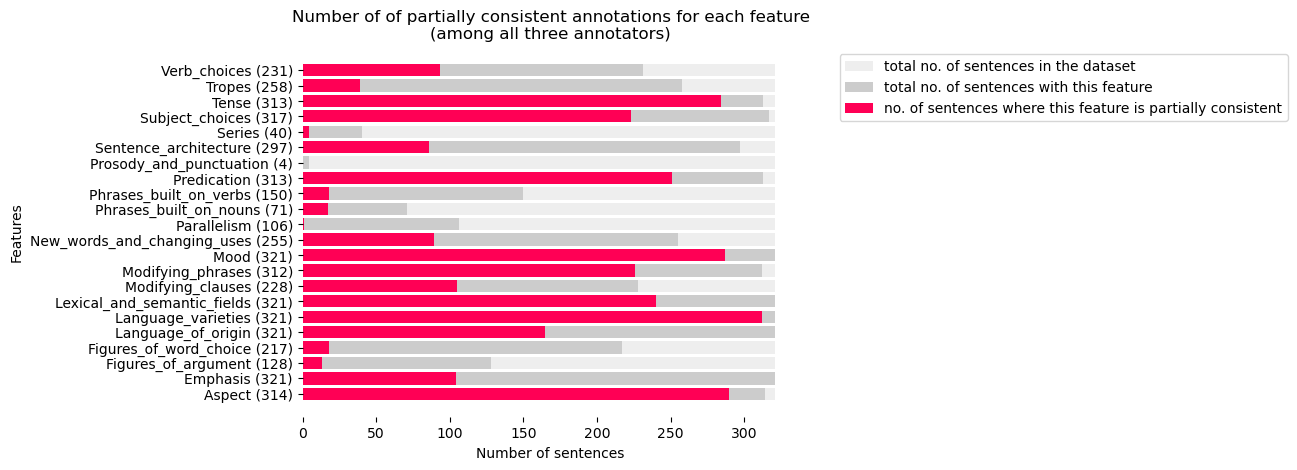

In [890]:
X = []
Y = []
Y3 = []
Y2 =[len(compare_sentences)]*len(feature_agreement)


for row in feature_agreement.iterrows():
    c = Counter(row[1][5])
    
    # c[-1] represents feature/properties which are not present in the annotation
    # c[0] represents no agreement
    # c[1] .. c[n] represents a feature where there are overlapping properties (partial agreement)
    
    
    null = c[-1]
    no_agreement = c[0]
    
    sum_not_null = sum(c.values())-c[-1]
    
    total_not_null = len(row[1][5])-c[-1]
    
    partial_agreement = sum(c.values())-c[-1]
    
    partial_agreement = sum_not_null - no_agreement
    
    # feature name and number of datapoints which are not null
    x = f"{row[1][0]} ({total_not_null})"
    y = partial_agreement #/(total_not_null)
    y_t = total_not_null
    
    X.append(x)
    Y.append(y)
    Y3.append(y_t)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee",label="total no. of sentences in the dataset")
ax.barh(X,Y3, color="#cccccc",label="total no. of sentences with this feature")
ax.barh(X,Y, color="#ff0055", label="no. of sentences where this feature is partially consistent")
ax.set_frame_on(False)
ax.set_xlabel('Number of sentences')
ax.set_ylabel('Features')
ax.set_title('Number of of partially consistent annotations for each feature\n(among all three annotators)')
plt.legend(loc='upper right', bbox_to_anchor=(2, 1.0))

plt.show()

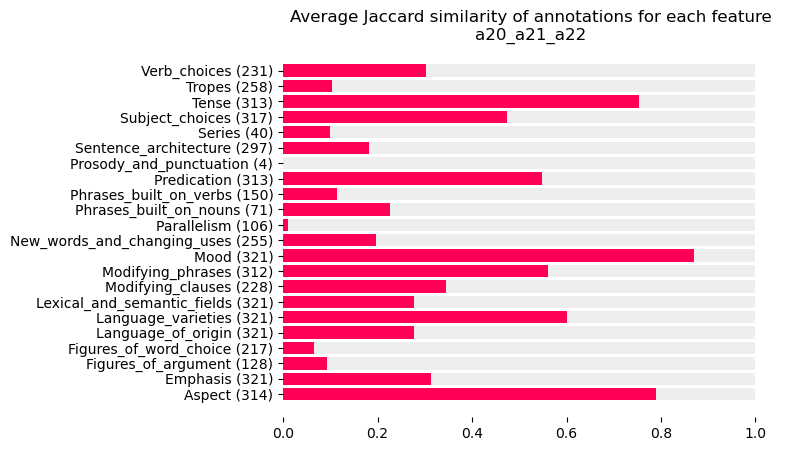

In [1033]:
j_feature_agreement = jaccard_df.groupby('feature').agg(list).reset_index()
# Jaccard agreement
X = []
Y = []
Y2 =[1.0]*len(j_feature_agreement)


for row in j_feature_agreement.iterrows():
    c = Counter(row[1][5]) # a20_a21_a22
    
    
    x = row[1][0] +" (" + str(sum(c.values())- c[-1])+")" # feature name and number of datapoints
    
    tot_jac = sum(row[1][5]) + c[-1]
    tot_non_null = len(row[1][5]) - c[-1]
    
    y = tot_jac/tot_non_null
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('Average Jaccard similarity of annotations for each feature\na20_a21_a22')
fig.savefig("a20_a21_a22_jaccard.svg",format="svg")
plt.show()

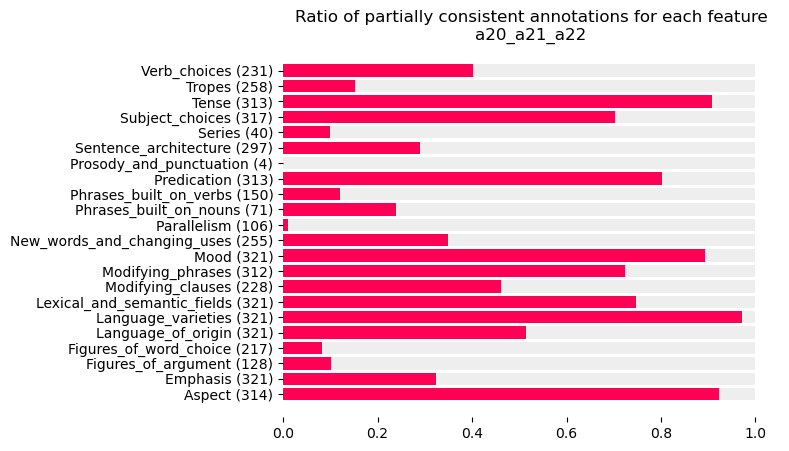

In [1034]:
feature_agreement = partial_df.groupby('feature').agg(list).reset_index()
X = []
Y = []
Y2 =[1.0]*len(feature_agreement)


for row in feature_agreement.iterrows():
    c = Counter(row[1][5]) # a20_a21_a22
    x = row[1][0] +" (" + str(sum(c.values())- c[-1])+")" # feature name and number of datapoints
    consistent = sum(c.values()) - c[0] - c[-1]
    inconsistent = c[0]
    y = consistent/(sum(c.values())-c[-1])
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('Ratio of partially consistent annotations for each feature\na20_a21_a22')
fig.savefig("a20_a21_a22_partial.svg",format="svg")
plt.show()

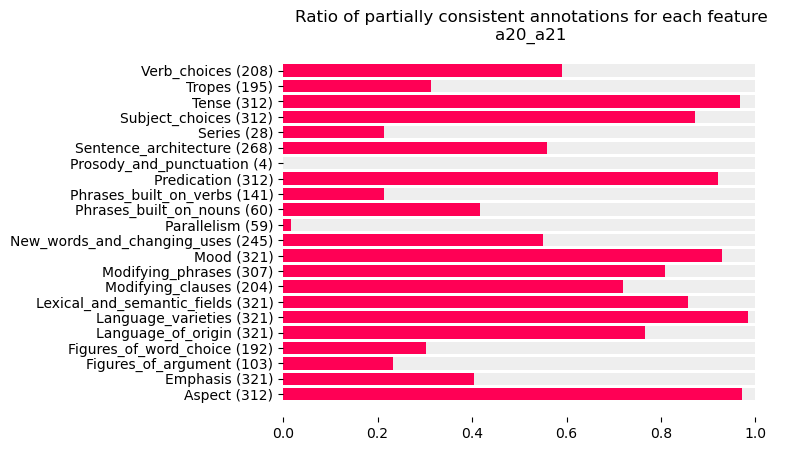

In [838]:
X = []
Y = []
Y2 =[1.0]*len(feature_agreement)


for row in feature_agreement.iterrows():
    c = Counter(row[1][2]) # a20_a21
    x = row[1][0] +" (" + str(sum(c.values())- c[-1])+")" # feature name and number of datapoints
    consistent = sum(c.values()) - c[0] - c[-1]
    inconsistent = c[0]
    y = consistent/(sum(c.values())-c[-1])
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('Ratio of partially consistent annotations for each feature\na20_a21')
fig.savefig("a20_a21_partial.svg",format="svg")
plt.show()

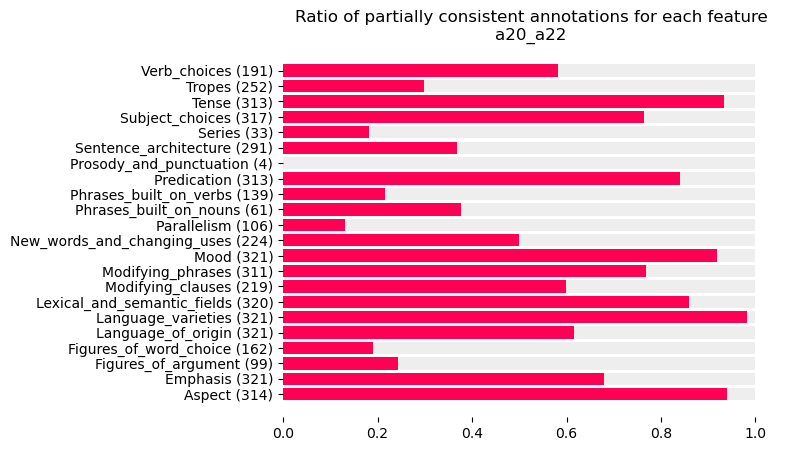

In [839]:
X = []
Y = []
Y2 =[1.0]*len(feature_agreement)


for row in feature_agreement.iterrows():
    data = Counter(row[1][2])
    c = Counter(row[1][3]) # a20_a22
    x = row[1][0] +" (" + str(sum(c.values())- c[-1])+")" # feature name and number of datapoints
    consistent = sum(c.values()) - c[0] - c[-1]
    inconsistent = c[0]
    y = consistent/(sum(c.values())-c[-1])
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('Ratio of partially consistent annotations for each feature\na20_a22')
fig.savefig("a20_a22_partial.svg",format="svg")
plt.show()

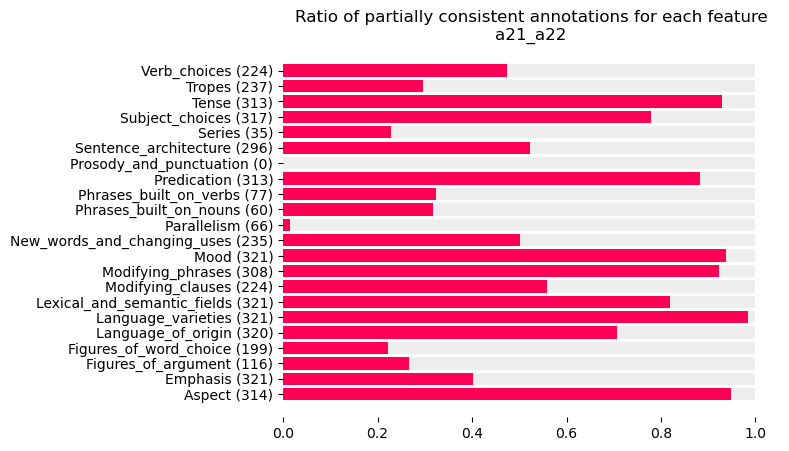

In [840]:
X = []
Y = []
Y2 =[1.0]*len(feature_agreement)


for row in feature_agreement.iterrows():
    data = Counter(row[1][2])
    c = Counter(row[1][4]) # a21_a22
    x = row[1][0] +" (" + str(sum(c.values())- c[-1])+")" # feature name and number of datapoints
    consistent = sum(c.values()) - c[0] - c[-1]
    inconsistent = c[0]
    y = consistent/(sum(c.values())-c[-1] + 0.000000001)
    X.append(x)
    Y.append(y)
    
fig, ax = plt.subplots()
ax.barh(X,Y2, color="#eeeeee")
ax.barh(X,Y, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('Ratio of partially consistent annotations for each feature\na21_a22')
fig.savefig("a21_a22_partial.svg",format="svg")
plt.show()

## Compare `consistent_gpt` and `annotator`

In [853]:
# Use only the sentences in all_consistent_sentence_ids
all_consistent_sentence_ids

[47, 265, 271, 319, 320, 650, 14038]

In [855]:
gpt=res_df
gpt.head()

,sentence_id,count,properties,feature_id,partial,partial_count
0,265,1,[{simple}],Aspect,{simple},1
2,265,1,[{subordinate}],Modifying_clauses,{subordinate},1
3,265,1,"[{multiplying and embedding modifiers, single ...",Modifying_phrases,"{multiplying and embedding modifiers, single w...",3
4,265,1,"[{Periodic sentences, left branching, middle b...",Sentence_architecture,"{Periodic sentences, left branching, middle br...",3
5,265,1,"[{by sentence role, by position}]",Emphasis,"{by sentence role, by position}",2


In [842]:
filtered_ann22 = df_22[df_22['sentence_id'].isin(all_consistent_sentence_ids)]
filtered_ann22

,sentence_id,date_updated,feature_id,properties
7,47,2023-07-21 13:15:06,Language_of_origin,[Old_English_Core]
7,47,2023-07-21 13:15:06,Language_varieties,"[clarity, correctness, middle, forcefulness]"
7,47,2023-07-21 13:15:06,Aspect,[simple]
7,47,2023-07-21 13:15:06,Mood,[indicative]
7,47,2023-07-21 13:15:06,Sentence_architecture,[right_branching]
...,...,...,...,...
350,14038,2023-09-20 06:20:04,Language_varieties,"[clarity, correctness, middle]"
350,14038,2023-09-20 06:20:04,Mood,[indicative]
350,14038,2023-09-20 06:20:04,Emphasis,[by_position]
350,14038,2023-09-20 06:20:04,Modifying_phrases,[prepositional_phrases]


In [843]:
dataframe = []

for sid in all_consistent_sentence_ids:
    comparison_dict = defaultdict()
    
    # filter by sentence id
    gpt = consistent_gpt[consistent_gpt['sentence_id']==sid]
    _22 = df_22[df_22['sentence_id']==sid]
    
    # get the set of features from both dataframes
    features = list(set(list(gpt['feature_id'])+list(_22['feature_id'])))
    
    # convert dataframes to dicts for eay access to properties
    gpt = dict(zip(gpt['feature_id'], gpt.properties))
    dict_22 = dict(zip(_22['feature_id'], _22.properties))
    
    
    for feature in features:
        if feature in gpt: 
            f1 = gpt[feature] 
        else: f1 = ""
        if feature in dict_22: 
            f2 = dict_22[feature] 
        else: f2 =  ""
        
        # append row with: sentence_id, feature, [gpt+properties, annotator_properites]
        dataframe.append([sid,feature,[f1,f2]])
    
    

In [844]:
# comparing annotator 22 with GPT. for each feature, the properties are a list of lists for [GPT, Annotator]
df = pd.DataFrame(dataframe, columns=['sentence_id','feature_id','properties'])

In [845]:
# generate columns for exact and partial matches
df['exact_match'] = df['properties'].apply(lambda x: x[0]==x[1])
df['partial_match'] = df['properties'].apply(lambda x: len(set(x[0]).intersection(set(x[1])))>0)

In [848]:
df.head()

,sentence_id,feature_id,properties,exact_match,partial_match
0,47,New_words_and_changing_uses,"[[], [conversions]]",False,False
1,47,Modifying_phrases,"[, [single_word_modifiers, prepositional_phras...",False,False
2,47,Sentence_architecture,"[, [right_branching]]",False,False
3,47,Tense,"[, [present, past]]",False,False
4,47,Verb_choices,"[, [negation]]",False,False


In [849]:
# group by feature for visualization purposes
df = df.groupby('feature_id').agg(list).reset_index()

In [850]:
df.loc[18]['sentence_id']

[47, 265, 271, 319, 320, 650]

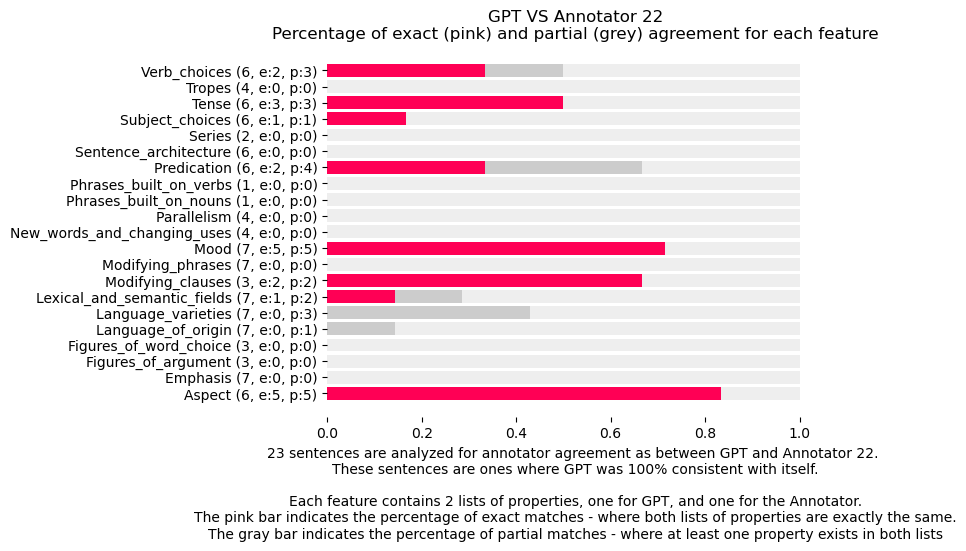

In [852]:
X = []
Y_exact = []
Y_partial = []
Y_100 =[1.0]*len(df)


for row in df.iterrows():

    feature = row[1][0]
    properties = row[1][2]
    exact_match = row[1][3]
    partial_match = row[1][4]
    
     # feature name and number of datapoints
    y_e = sum(exact_match)/len(properties)
    y_p = sum(partial_match)/len(properties)
    
    x = feature +" (" + str(len(properties))+", e:"+str(sum(exact_match))+", p:"+str(sum(partial_match))+")"
    
    X.append(x)
    Y_exact.append(y_e)
    Y_partial.append(y_p)
    
fig, ax = plt.subplots()
ax.barh(X,Y_100, color="#eeeeee")
ax.barh(X,Y_partial, color="#cccccc")
ax.barh(X,Y_exact, color="#ff0055")
ax.set_frame_on(False)
ax.set_title('GPT VS Annotator 22\nPercentage of exact (pink) and partial (grey) agreement for each feature')
plt.xlabel('''23 sentences are analyzed for annotator agreement as between GPT and Annotator 22. 
These sentences are ones where GPT was 100% consistent with itself.\n
Each feature contains 2 lists of properties, one for GPT, and one for the Annotator.
The pink bar indicates the percentage of exact matches - where both lists of properties are exactly the same.
The gray bar indicates the percentage of partial matches - where at least one property exists in both lists''')


plt.show()

# Binomial hypthesis test - one sided
https://en.wikipedia.org/wiki/Binomial_test

1. First, for each feature, calculate the chance of success (agreement) at randon given equal probability on each outcome
2. Next, calculate the p-value using the binomial test given the data above

Tense. There are 4 possible propeties of tense (present, past, future, progression). 

n=4, r=2

Permutation with replcament:   
P_R(n,r) = n^r

Probability of agreement = n/(n^r)

4/(4**2) = 0.25


<img src="tense-prob.png" width=50%>

In [130]:
# Tense
n = 4 # number of properties, and as such, number of possible successes
r = 2 # number of annotators
PR = n**r # Permutations with replacement (number of possibilities)
P = n/PR # Probability of success (agreement)
P

0.25

In [133]:
n_trials = 23 # number of sentences
n_success = 13 # number of agreements
P = .25 # Chance of success at randon given equal probability on each outcome
scipy.stats.binomtest(13, n=23, p=P, alternative='greater') #(one-tailed test - that the result is greater than random)

BinomTestResult(k=13, n=23, alternative='greater', proportion_estimate=0.5652173913043478, pvalue=0.0012431136583188618)

In [134]:
# Verb choices
n = 5
r = 2
P = n/(n**r)
P

0.2

In [135]:
scipy.stats.binomtest(2, 12, P, alternative='greater') #(one-tailed test)

BinomTestResult(k=2, n=12, alternative='greater', proportion_estimate=0.16666666666666666, pvalue=0.7251220930559998)

In [136]:
# Aspect
n = 4
r = 2
P = n/(n**r)
P

0.25

In [137]:
scipy.stats.binomtest(16, 23, P, alternative='greater') #(one-tailed test)

BinomTestResult(k=16, n=23, alternative='greater', proportion_estimate=0.6956521739130435, pvalue=8.792154176262557e-06)

In [138]:
import sklearn
from sklearn.metrics import cohen_kappa_score

In [139]:
df

,feature_id,sentence_id,properties,exact_match,partial_match
0,Aspect,"[16, 32, 47, 50, 258, 263, 271]","[[, [simple]], [, [simple]], [, [simple]], [, ...","[False, False, False, False, True, True, True]","[False, False, False, False, True, True, True]"
1,Emphasis,"[16, 32, 47, 50, 258, 263, 271, 9329, 13483, 1...","[[, [by_position]], [, [by_position]], [, [by_...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
2,Figures_of_argument,"[47, 258, 263, 271, 13483]","[[, [strategic_repetition]], [, [strategic_rep...","[False, False, False, False, False]","[False, False, False, False, False]"
3,Figures_of_word_choice,"[47, 258, 263, 271]","[[, [emphasis]], [[ploce], [emphasis]], [[poly...","[False, False, False, False]","[False, False, False, False]"
4,Language_of_origin,"[16, 32, 47, 50, 258, 263, 271, 9329, 13483, 1...","[[[Old English Core, Latin/Greek, Norman Frenc...","[False, False, False, False, False, False, Fal...","[True, False, False, False, True, False, True,..."
5,Language_varieties,"[16, 32, 47, 50, 258, 263, 271, 9329, 13483, 1...","[[, [clarity, correctness, middle]], [, [clari...","[False, False, False, False, False, False, Fal...","[False, False, False, False, True, True, True,..."
6,Lexical_and_semantic_fields,"[16, 32, 47, 50, 258, 263, 271, 9329, 13483]","[[, [definite/hypothesis]], [, [definite/hypot...","[False, False, False, False, False, True, Fals...","[False, False, False, False, True, True, True,..."
7,Modifying_clauses,"[16, 32, 47, 258, 263, 271, 13483]","[[, [adjective]], [, [noun]], [, [adjective]],...","[False, False, False, False, False, True, False]","[False, False, False, True, False, True, False]"
8,Modifying_phrases,"[16, 32, 47, 50, 258, 271, 9329, 13483, 14038]","[[, [single_word_modifiers, prepositional_phra...","[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal..."
9,Mood,"[16, 32, 47, 50, 258, 263, 271, 9329, 13483, 1...","[[, [indicative]], [, [indicative]], [, [indic...","[False, False, False, False, False, True, True...","[False, False, False, False, True, True, True,..."


In [140]:
props = df['properties'].to_numpy()

In [141]:
f = 3

In [142]:
props[f]

[['', ['emphasis']],
 [['ploce'], ['emphasis']],
 [['polyptoton', 'synonyms'], ['anatanaclasis']],
 [[], '']]

In [143]:
y1 = np.array(props[f])[:,0:1]
y2 = np.array(props[f])[:,1:]

/var/folders/vt/g1t9ds3s01z05zs4qg2dngk80000gn/T/ipykernel_38923/655591041.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y1 = np.array(props[f])[:,0:1]
/var/folders/vt/g1t9ds3s01z05zs4qg2dngk80000gn/T/ipykernel_38923/655591041.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y2 = np.array(props[f])[:,1:]


In [144]:
y2 = ["".join(sorted(item[0])) for i, item in enumerate(y2)]
y2

['emphasis', 'emphasis', 'anatanaclasis', '']

In [145]:
# y1[1][0] = list([''])
# y1[0][0] = list([''])

In [146]:
y1 = ["".join(sorted(item[0])) for i, item in enumerate(y1)]

In [147]:
y1

['', 'ploce', 'polyptotonsynonyms', '']

In [148]:
sklearn.metrics.cohen_kappa_score(y1, y2)

0.1428571428571429

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*mHB6Ciljb4OnOacNWgc0aw.png">